In [148]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from specutils import Spectrum1D
from specutils.fitting import find_lines_threshold, find_lines_derivative
from scipy.optimize import curve_fit
from astropy.stats import sigma_clip
from glob import glob
from scipy.signal import find_peaks

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [ ]:
#spectrum_files = glob(os.path.join('HST','anonymous37141', '*x1dsum.fits'))

In [ ]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [181]:
spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [182]:
spectrum_header = [fits.getheader(file, ext=0) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [167]:
date = [header['DATE'] for header in spectrum_header]
observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header]
instrument_filter = [header['OPT_ELEM'] for header in spectrum_header]

KeyError: "Keyword 'ROOTNAME' not found."

In [168]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
lab_emission_lines = lines['lab_lambda']
transition_grouped_lines = lines.groupby("[nu', J']")

In [170]:
spectrum_x1d

[<Table length=1>
       WAVELENGTH                     FLUX              ...   EFF_EXPTIME   
        Angstrom             erg / (Angstrom s cm2)     ...        s        
     float32[33111]              float32[33111]         ...  float32[33111] 
 ---------------------- ------------------------------- ... ----------------
 1395.5248 .. 1801.2026 1.25739026e-14 .. 2.3127259e-14 ... 220.0 .. 220.032]

In [171]:
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.concatenate(spectrum_x1d[0]['WAVELENGTH'])*u.AA
wavesort_idx = np.argsort(x1d_wavelength)
x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.concatenate(spectrum_x1d[0]['FLUX'])*flux_units
x1d_fluxerr = np.concatenate(spectrum_x1d[0]['ERROR'])*flux_units

x1d_flux = x1d_flux[wavesort_idx]
x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [155]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [172]:
peaks , _ = find_peaks(x1d_flux, height=max(x1d_fluxerr.value), distance=100)

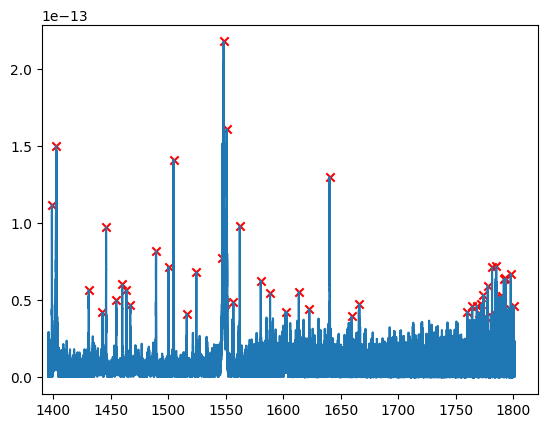

In [173]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [174]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

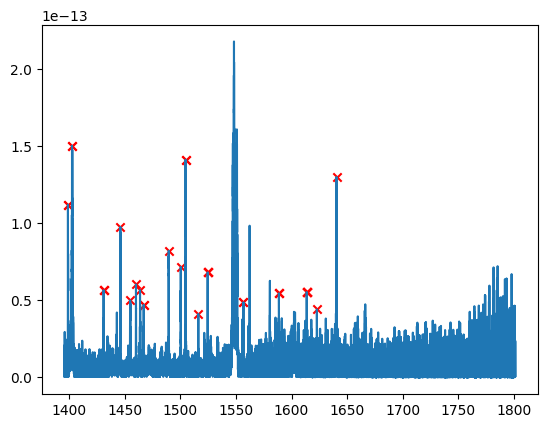

In [175]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [176]:
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-150:idx+150] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-150:idx+150] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-150:idx+150] for idx in x1d_h2_emissions_idx]

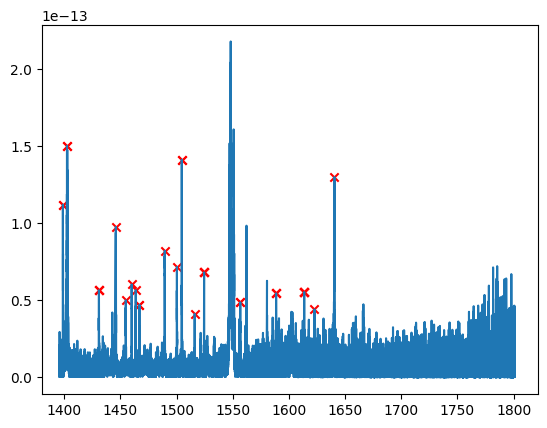

In [177]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [178]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = np.asarray(x1d_h2_emissions_flux)
fluxerr = np.asarray(x1d_h2_emissions_fluxerr)
wavelength = np.asarray(x1d_h2_emissions_wavelength)

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)


In [179]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

,Line ID,"[nu', J']",lab_lambda,spec_flux,spec_fluxerr,spec_wavelength
"[nu', J']",,,,,,
"[3,13]",(3–10)R(12),"[3,13]",1615.43,"[-9.423934e-17, -9.424308e-17, 5.977108e-15, 1...","[3.9167807e-15, 3.9170264e-15, 6.0009697e-15, ...","[1611.8047, 1611.8169, 1611.8291, 1611.8414, 1..."
"[4,13]",(4–8)R(12),"[4,13]",1509.45,"[3.6904904e-15, 3.4229057e-15, 1.0949009e-14, ...","[2.625002e-15, 2.431868e-15, 4.4772544e-15, 3....","[1502.807, 1502.8193, 1502.8315, 1502.8439, 15..."
"[4,13]",(4–11)R(12),"[4,13]",1613.99,"[-9.423934e-17, -9.424308e-17, 5.977108e-15, 1...","[3.9167807e-15, 3.9170264e-15, 6.0009697e-15, ...","[1611.8047, 1611.8169, 1611.8291, 1611.8414, 1..."
"[3,16]",(3–7)R(15),"[3,16]",1513.99,"[2.6003964e-15, 3.9247644e-15, 7.9152e-15, 5.2...","[1.8653165e-15, 2.2708352e-15, 3.238226e-15, 2...","[1514.3121, 1514.3243, 1514.3365, 1514.3489, 1..."
"[3,16]",(3–9)R(15),"[3,16]",1593.26,"[3.091183e-15, 5.5479447e-15, 5.6012095e-15, 8...","[3.1251414e-15, 3.956151e-15, 3.988064e-15, 4....","[1586.7975, 1586.8097, 1586.8219, 1586.8342, 1..."
"[3,16]",(3–10)R(15),"[3,16]",1621.12,"[6.014116e-15, 6.0142545e-15, 1.2285056e-14, 6...","[6.1467004e-15, 6.1468482e-15, 8.687098e-15, 6...","[1620.945, 1620.9572, 1620.9695, 1620.9817, 16..."
"[4,4]",(4–9)P(5),"[4,4]",1526.55,"[8.073332e-15, 4.062993e-15, 4.0368853e-15, 5....","[3.3055886e-15, 2.3604066e-15, 2.3505147e-15, ...","[1522.705, 1522.7173, 1522.7295, 1522.7417, 15..."
"[4,4]",(4–11)P(5),"[4,4]",1613.72,"[-9.423934e-17, -9.424308e-17, 5.977108e-15, 1...","[3.9167807e-15, 3.9170264e-15, 6.0009697e-15, ...","[1611.8047, 1611.8169, 1611.8291, 1611.8414, 1..."
"[1,7]",(1–6)P(8),"[1,7]",1467.08,"[4.5038017e-15, 1.3697678e-14, 5.94287e-15, 6....","[2.2597291e-15, 3.9561114e-15, 2.6670846e-15, ...","[1465.1431, 1465.1554, 1465.1676, 1465.1798, 1..."


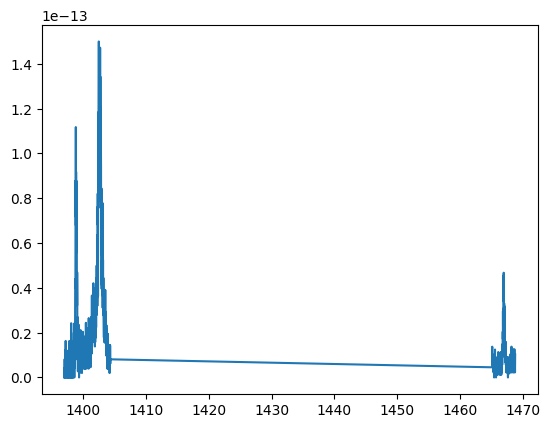

In [180]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function